# Задача сегментирования сигаретных окурков 

# Импортирование нужных библиотек

In [1]:
#выполните следующие строчки в google colab, чтобы подгрузить библиотеку segmutils
!git clone https://github.com/RostislavKorst/cigarette_butt_segmentation.git && pip install -r cigarette_butt_segmentation/requirements.txt
import sys; sys.path.append('./cigarette_butt_segmentation')

Cloning into 'cigarette_butt_segmentation'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.
     |████████████████████████████████| 696kB 48.3MB/s 
     |████████████████████████████████| 25.4MB 118kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
# Будем использовать PyTorch (в colab он уже установлен и можно пользоваться gpu, поэтому лучше запускать решение на колабе)

# to reload modules before executing user code (docs)
%load_ext autoreload
%autoreload 2

# Импортируем нужные библиотеки 
import numpy as np
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image, ImageDraw
from gluoncv import utils
import torch.nn as nn
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import random
import os

# Для построения графиков 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 8.0)

# Зафиксируем сиды для воспроизводимости решений 
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Импортируем нужные функции из гитхаб репозитория 
import segmutils
from segmutils.data.segm2mask import segm2mask

# Датасет
### (Описание скопировано с www.immersivelimit.com)
## This dataset consists of a set of 2200 synthetically composed images of cigarettes on the ground. It is designed for training CNNs (convolutional neural networks).

* Annotations: Segmented, object-detection COCO format with custom categories. For more info, check out http://cocodataset.org/#format-data
* Composition: Images were composed automatically with custom code utilizing the Python Imaging Library to apply random scale, rotation, brightness, etc to the foreground cutouts
* Location: Photos of the ground and cigarette butts were taken in Austin, Texas
* Camera: iPhone 8, original pixel resolution 3024 x 4032

### The dataset is by Adam Kelly from https://www.immersivelimit.com/datasets/cigarette-butts

# Препроцессинг данных 

In [3]:
# Подгружаю датасет со своего гугл диска по причине того, что в репозиторий 
# github датасет не помещается даже в форме архива, поэтому данный код 
# не воспроизводим, по причине того, что в гугл диске нужна авторизация 
# (как подгружать датасет с оригинального сайта из кода - я не разобрался)

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Пути до картинок, и аннотаций к ним
path2train_data = '/content/drive/My Drive/Cigs/train/images'
path2train_json = '/content/drive/My Drive/Cigs/train/coco_annotations_test.txt'
path2val_data = '/content/drive/My Drive/Cigs/val/images'
path2val_json = '/content/drive/My Drive/Cigs/val/coco_annotations_val.txt'

### Пояснение по альтернативной и более правильной загрузке датасета 

In [0]:
# С помощью прямой ссылки на zip-файл датасета, (которую можно получить
# например в платной весии dropbox), изображения можно подгрузить
# таким образом:

# %%shell
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# unzip PennFudanPed.zip

## Рассмотрим, что из себя представляет датасет

In [6]:
cap = dset.CocoDetection(root=path2train_data,
                        annFile=path2train_json,
                        transform=transforms.ToTensor())
img, target = cap[9] # 9 ая фотография в тренировочной выборке

loading annotations into memory...
Done (t=1.40s)
creating index...
index created!


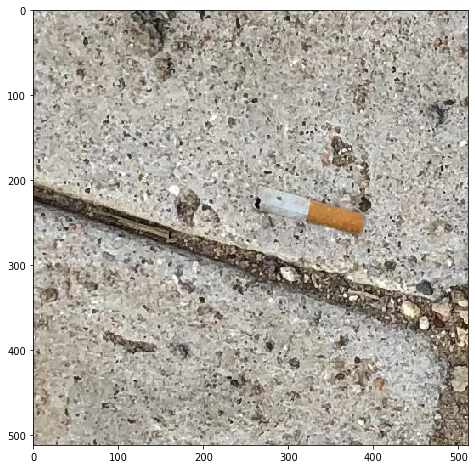

In [7]:
plt.imshow(img.permute(1, 2, 0));

## Финальная предобработка датасета 

In [8]:
# Определим некоторые трансформации для датасета(нам нужно изменить размер
# изображений и преобразовать их в torch Tensor) и загрузим его
# в переменные coco_train и coco_val

transforms1 = list()
transform1 = torchvision.transforms.Resize((572, 572), interpolation=2)
transforms1.append(transform1)
transform2 = torchvision.transforms.ToTensor()
transforms1.append(transform2)
transformation = torchvision.transforms.Compose(transforms1)

coco_train = dset.CocoDetection(root=path2train_data,
                        annFile=path2train_json,
                        transform=transform2)

print('Number of train samples: ', len(coco_train))
print()

coco_val = dset.CocoDetection(root=path2val_data,
                        annFile=path2val_json,
                        transform=transform2)

print('Number of val samples: ', len(coco_val))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Number of train samples:  2000

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
Number of val samples:  200


In [0]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed

In [0]:
# Облачим выборку в класс наследник Dataset, переопределив в нем нужные
# магические методы для получения размера датасета и доступа по индексу 

class CigarettesDataset(torch.utils.data.Dataset):
    def __init__(self, coco_data, transforms=None):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.data = coco_data

    def __getitem__(self, idx):

        # form segm_list 
        img, target = self.data[idx]
        segm_list = target[0]['segmentation'][0];

        mask = segm2mask(segm_list)

        masks = mask

        # get bounding box coordinates for each mask
        num_objs = 1
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            bounding_boxes = target[0]['bbox'] 
            xmin, ymin, delta_x, delta_y = bounding_boxes
            boxes.append([xmin, ymin, xmin + delta_x, ymin + delta_y])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor([masks], dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd 

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.data)

In [0]:
dataset = CigarettesDataset(coco_train)
dataset_test = CigarettesDataset(coco_val)

def collate_fn(batch):
    return tuple(zip(*batch))

# Облачим датасет в даталоадер для итерирования по датасету по батчам 
# (небольшими группами изображений для большего числа градиентных шагов
# за эпоху и облегчения вычислений)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# Определим модель для сегментации 

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [14]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 6836 (delta 3), reused 2 (delta 0), pack-reused 6818
Receiving objects: 100% (6836/6836), 9.79 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (4599/4599), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [17]:
from tqdm import tqdm 
# let's train it for 10 epochs
num_epochs = 3

for epoch in tqdm(range(num_epochs)):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: [0]  [   0/1000]  eta: 0:53:31  lr: 0.000010  loss: 4.0512 (4.0512)  loss_classifier: 0.8262 (0.8262)  loss_box_reg: 0.0379 (0.0379)  loss_mask: 3.1765 (3.1765)  loss_objectness: 0.0081 (0.0081)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 3.2117  data: 1.3601  max mem: 1518
Epoch: [0]  [  10/1000]  eta: 0:14:41  lr: 0.000060  loss: 3.0340 (3.0304)  loss_classifier: 0.8169 (0.7631)  loss_box_reg: 0.0758 (0.0685)  loss_mask: 2.2746 (2.1833)  loss_objectness: 0.0081 (0.0125)  loss_rpn_box_reg: 0.0028 (0.0030)  time: 0.8900  data: 0.1278  max mem: 1793
Epoch: [0]  [  20/1000]  eta: 0:12:45  lr: 0.000110  loss: 1.1706 (1.9497)  loss_classifier: 0.5099 (0.5196)  loss_box_reg: 0.0758 (0.0719)  loss_mask: 0.6058 (1.3408)  loss_objectness: 0.0050 (0.0141)  loss_rpn_box_reg: 0.0031 (0.0032)  time: 0.6599  data: 0.0055  max mem: 1793
Epoch: [0]  [  30/1000]  eta: 0:12:01  lr: 0.000160  loss: 0.5818 (1.4748)  loss_classifier: 0.1181 (0.3839)  loss_box_reg: 0.0770 (0.0762)  loss_mask: 0.2966 (

 33%|███▎      | 1/3 [13:49<27:38, 829.07s/it]

Test:  [199/200]  eta: 0:00:00  model_time: 0.1223 (0.1232)  evaluator_time: 0.0022 (0.0028)  time: 0.1303  data: 0.0031  max mem: 1835
Test: Total time: 0:00:26 (0.1333 s / it)
Averaged stats: model_time: 0.1223 (0.1232)  evaluator_time: 0.0022 (0.0028)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.845
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.841
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.862
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.872
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=

 67%|██████▋   | 2/3 [25:50<13:16, 796.81s/it]

Test:  [199/200]  eta: 0:00:00  model_time: 0.1243 (0.1248)  evaluator_time: 0.0022 (0.0026)  time: 0.1315  data: 0.0031  max mem: 1835
Test: Total time: 0:00:26 (0.1349 s / it)
Averaged stats: model_time: 0.1243 (0.1248)  evaluator_time: 0.0022 (0.0026)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.857
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.854
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.872
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.886
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=

100%|██████████| 3/3 [37:52<00:00, 774.34s/it]

Test:  [199/200]  eta: 0:00:00  model_time: 0.1243 (0.1248)  evaluator_time: 0.0022 (0.0024)  time: 0.1315  data: 0.0032  max mem: 1835
Test: Total time: 0:00:26 (0.1342 s / it)
Averaged stats: model_time: 0.1243 (0.1248)  evaluator_time: 0.0022 (0.0024)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.860
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.858
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.857
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.888
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=

In [0]:
# pick one image from the test set
img, _ = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [19]:
prediction

[{'boxes': tensor([[254.2988, 116.2833, 331.6773, 171.6150]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([1.0000], device='cuda:0')}]

In [0]:
img, _ = coco_val[5]

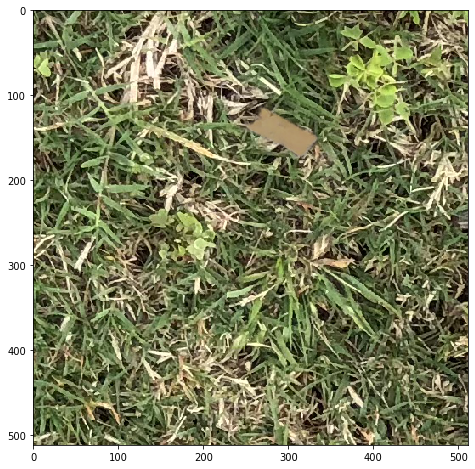

In [26]:
plt.imshow(img.permute(1, 2, 0));

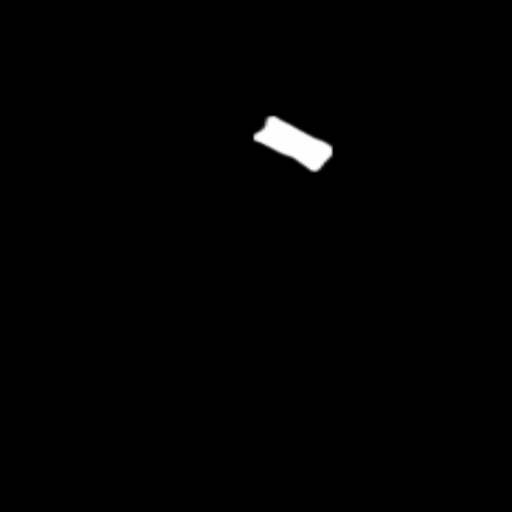

In [21]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [0]:
path_to_test = r'/content/drive/My Drive/Cigs/0004.JPG'

!cp "/content/drive/My Drive/Cigs/0004.JPG" "0004.JPG"

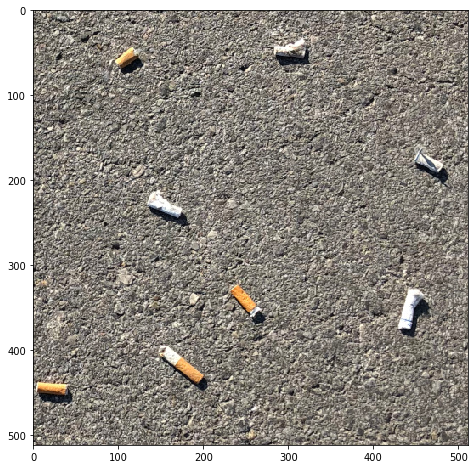

In [49]:
from PIL import Image

img = Image.open(path_to_test)
plt.imshow(img);

In [0]:
trans1 = transforms.ToTensor()
real_test_image = trans1(img)

In [0]:
with torch.no_grad():
    prediction = model([real_test_image.to(device)])

In [65]:
prediction[0]['masks'].shape

torch.Size([9, 1, 512, 512])

In [59]:
len(prediction[0]['masks'])

9

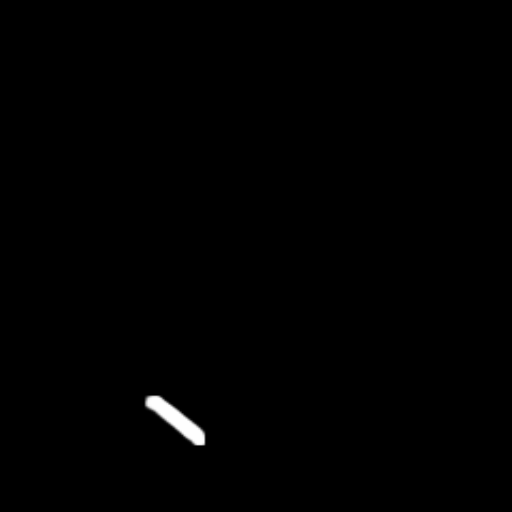

In [73]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())